# RDR and BAF plots in Numbat style

2026-01
Jiamu James Qiao

https://github.com/hxj5/bcd/blob/master/scripts/utils.py

### 1. Generate sample df

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Sample df_genome
chroms = ['1', '2', '3']
arms = ['p', 'q']
data_genome = []
for chrom in chroms:
    for arm in arms:
        length = np.random.randint(100000000, 300000000)
        data_genome.append({'chrom': chrom, 'arm': arm, 'length': length})
df_genome = pd.DataFrame(data_genome)

# Sample df_snp
num_snps = 1000
df_snp_data = {
    'chrom': np.random.choice(chroms, num_snps),
    'pos': np.random.randint(1, 200000000, num_snps),
    'hap': np.random.choice([0, 1], num_snps),
    'AF': np.random.uniform(0, 1, num_snps)
}
df_snp = pd.DataFrame(df_snp_data)

# Sample df_gene
num_genes = 500
df_gene_data = {
    'chrom': np.random.choice(chroms, num_genes),
    'start': np.random.randint(1, 100000000, num_genes),
    'gene': ['gene_' + str(i) for i in range(num_genes)],
    'log2FC': np.random.uniform(-2, 2, num_genes)
}
df_gene_data['end'] = [start + np.random.randint(1000, 100000) for start in df_gene_data['start']]
df_gene = pd.DataFrame(df_gene_data)

In [2]:
df_genome

,chrom,arm,length
0,1,p,299900595
1,1,q,156755036
2,2,p,291100010
3,2,q,227521863
4,3,p,255299516
5,3,q,247532820


In [3]:
df_snp

,chrom,pos,hap,AF
0,3,92815366,0,0.372167
1,2,98164034,0,0.432077
2,3,57975252,1,0.439405
3,3,137311964,0,0.612940
4,3,182087755,1,0.943076
...,...,...,...,...
995,3,141996477,0,0.919531
996,3,41654365,1,0.993255
997,3,186400694,1,0.044911
998,1,131651519,0,0.761008


In [4]:
df_gene

,chrom,start,gene,log2FC,end
0,1,62022455,gene_0,1.904748,62092973
1,2,14693326,gene_1,0.733815,14739609
2,3,49359782,gene_2,-0.498236,49442108
3,3,10854521,gene_3,1.200294,10867726
4,1,43965825,gene_4,1.538333,44056699
...,...,...,...,...,...
495,3,13657006,gene_495,-0.672007,13708019
496,1,12006206,gene_496,0.651185,12015552
497,3,12998379,gene_497,1.482536,13084793
498,2,6767568,gene_498,1.036348,6802240


### 2. Plot

In [11]:
# First draft generated by Grok

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Custom cmap for red-green-blue
rgb_cmap = LinearSegmentedColormap.from_list('rgb', ['red', 'green', 'blue'])

def get_cumulative_positions(df, df_genome, pos_col='pos', chrom_col='chrom'):
    chrom_lengths = df_genome.groupby('chrom')['length'].sum()
    chroms = sorted(chrom_lengths.index)
    start_dict = {}
    cumul = 0
    for c in chroms:
        start_dict[c] = cumul
        cumul += chrom_lengths[c]
    df['cumul_pos'] = df[chrom_col].map(start_dict) + df[pos_col]
    mid_points = [start_dict[c] + chrom_lengths[c] / 2 for c in chroms]
    return df, chroms, mid_points, cumul

def plot_psbulk_baf(
    df_snp,
    df_genome,
    use_pos=True,
    min_depth=8,
    dot_size=0.8,
    dot_alpha=0.5,
    legend=True,
    exclude_gap=True,
    genome='hg38',
    text_size=10,
):
    """Visualize CNA BAF signal in pseudobulks, aggregating cells by clone."""
    # Assume df_snp has DP if min_depth used, but since not in input, skip filter for now
    # Compute pHF
    df_snp = df_snp.copy()
    df_snp['pHF'] = df_snp.apply(lambda row: row['AF'] if row['hap'] == 0 else 1 - row['AF'], axis=1)
    # Get cumulative
    df_snp, chroms, mid_points, total_length = get_cumulative_positions(df_snp, df_genome)
    fig, ax = plt.subplots(figsize=(20, 3))
    scatter = ax.scatter(
        df_snp['cumul_pos'],
        df_snp['pHF'],
        c=df_snp['pHF'],
        cmap=rgb_cmap,
        s=dot_size,
        alpha=dot_alpha,
    )
    ax.set_xlim(0, total_length)
    ax.set_ylim(0, 1)
    ax.axhline(0.5, color='gray', linestyle='dashed', linewidth=0.5)
    ax.set_xticks(mid_points)
    ax.set_xticklabels(chroms, fontsize=text_size)
    ax.set_xlabel('Chromosome', fontsize=text_size)
    ax.set_ylabel('pHF', fontsize=text_size)
    if legend:
        fig.colorbar(scatter, ax=ax, label='pHF')
    plt.tight_layout()
    return fig

def plot_psbulk_rdr(
    df_gene,
    df_genome,
    use_pos=True,
    exp_limit=2,
    dot_size=0.8,
    dot_alpha=0.5,
    legend=True,
    exclude_gap=True,
    genome='hg38',
    text_size=10,
):
    """Visualize CNA RDR signal in pseudobulks, aggregating cells by clone."""
    df_gene = df_gene.copy()
    df_gene['log2FC'] = df_gene['log2FC'].clip(-exp_limit, exp_limit)
    # Use mid position for genes
    df_gene['pos'] = (df_gene['start'] + df_gene['end']) / 2
    df_gene, chroms, mid_points, total_length = get_cumulative_positions(df_gene, df_genome, pos_col='pos')
    fig, ax = plt.subplots(figsize=(20, 3))
    scatter = ax.scatter(
        df_gene['cumul_pos'],
        df_gene['log2FC'],
        c=df_gene['log2FC'],
        cmap=rgb_cmap,
        s=dot_size,
        alpha=dot_alpha,
    )
    ax.set_xlim(0, total_length)
    ax.set_ylim(-exp_limit, exp_limit)
    ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
    ax.set_xticks(mid_points)
    ax.set_xticklabels(chroms, fontsize=text_size)
    ax.set_xlabel('Chromosome', fontsize=text_size)
    ax.set_ylabel('log2FC', fontsize=text_size)
    if legend:
        fig.colorbar(scatter, ax=ax, label='log2FC')
    plt.tight_layout()
    return fig

def plot_psbulk(
    df_gene,
    df_snp,
    df_genome,
    use_pos=True,
    min_depth=8,
    exp_limit=2,
    dot_size=0.8,
    dot_alpha=0.5,
    legend=True,
    exclude_gap=True,
    genome='hg38',
    text_size=10,
):
    fig_baf = plot_psbulk_baf(df_snp, df_genome, use_pos=use_pos, min_depth=min_depth, dot_size=dot_size, dot_alpha=dot_alpha, legend=legend, exclude_gap=exclude_gap, genome=genome, text_size=text_size)
    fig_rdr = plot_psbulk_rdr(df_gene, df_genome, use_pos=use_pos, exp_limit=exp_limit, dot_size=dot_size, dot_alpha=dot_alpha, legend=legend, exclude_gap=exclude_gap, genome=genome, text_size=text_size)
    # To combine, perhaps print both, or return list
    return fig_baf, fig_rdr

(<Figure size 2000x300 with 2 Axes>, <Figure size 2000x300 with 2 Axes>)

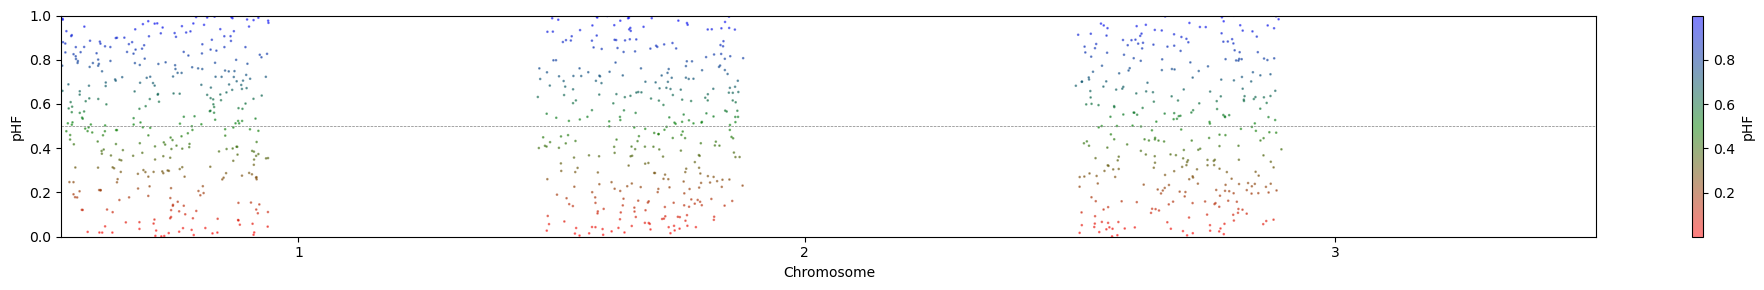

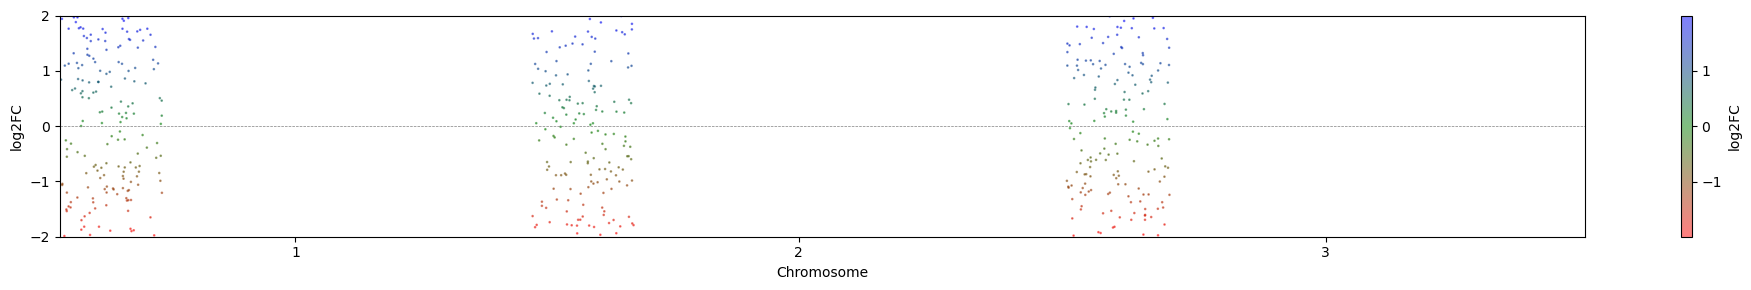

In [12]:
plot_psbulk(df_gene, df_snp, df_genome)